# [E-03]Cat_whiskers
## 고양이 수염 스티커 만들기

#### 필요한 모듈을 import 합니다.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

#### 준비한 이미지를 읽어옵니다.

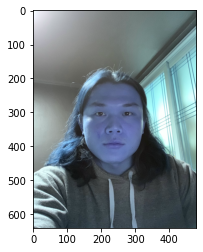

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

#### opencv는 BGR(파랑, 녹색, 빨강)을 사용하기에 위의 이미지와 같이 사진이 푸르스름하게 출력되는 것을 볼 수 있습니다.
#### BGR을 matplotlib을 통해서 RGB(빨강, 녹색, 파랑)으로 바꾸어 보정합니다.

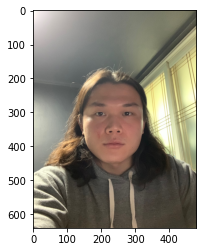

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

#### dlib의 face detector을 통해서 얼굴을 찾습니다.


dlib를 활용해서 detector을 선언합니다. 
이후 detector_hog를 이용하여 얼굴의 bounding box를 추출합니다.

In [4]:
# dlib를 활용해서 detector을 선언합니다.
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용하여 얼굴의 bounding box를 추출합니다.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해줍니다.
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

#### detector을 통해 찾아낸 얼굴을 출력합니다.

얼굴을 감지하여 녹색 박스가 나왔습니다.

rectangles[[(139, 263) (324, 449)]]


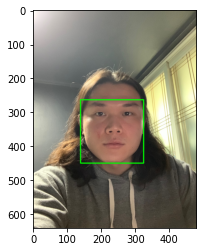

In [5]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### face landmark localization 기술을 이용해서 이목구비의 위치를 추론합니다.
스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 알아야 합니다.

#### dlib landmark localization을 통해서 68개의 이목구비 위치를 찾아줍니다.
저장한 landmark 모델을 불러온 다음 얼굴 영역 박스 마다 face landmark를 찾아냅니다.

이후 face landmark 좌표를 저장합니다.

In [6]:
# 저장한 landmark 모델을 불러옵니다
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


#### 랜드마크를 이미지에 출력해 봅니다.


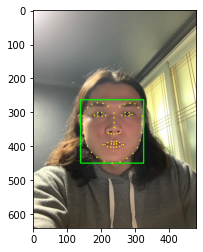

In [7]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 스티커 적용하기
#### 고양이 수염을 정확하게 적용하기 위해서 코 끝 중간 부분의 랜드마크 좌표를 이용해 줍니다.

In [8]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코 끝 중간 부분의 index는 33 입니다
    x = landmark[33][0]
    y = landmark[33][1] + dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(237, 364)
(x,y) : (237,457)
(w,h) : (186,186)


#### 고양이 수염 스티커의 이미지를 읽어서 적용합니다.

스티커를 바로 적용했더니 흰 배경이 얼굴을 뒤덮어서 얼굴을 볼 수가 없었기 때문에 255 - img_sticker을 통해서 색 반전해줬습니다.

In [9]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = 255 - img_sticker
print (img_sticker.shape)

(186, 186, 3)


#### 스티커의 이미지를 확인합니다.

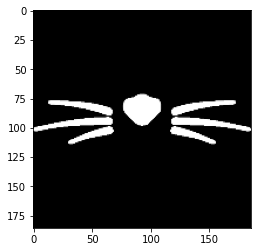

In [10]:
plt.imshow(img_sticker)
plt.show()


#### 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다.

In [11]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (144,271)


#### 아래 주석 처리 한 코드들은 좌표의 값이 음수로 나왔을 때 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주는 코드입니다.

In [12]:
#if refined_x < 0: 
#    img_sticker = img_sticker[:, -refined_x:]
#    refined_x = 0
#if refined_y < 0:
#    img_sticker = img_sticker[-refined_y:, :]
#    refined_y = 0
#
#print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

#### 원본 이미지에 스티커를 적용하고 이미지를 출력합니다.

이미지에 스티커를 적용했지만 얼굴에 랜드마크가 그대로 남아있는 것을 확인할 수 있습니다.

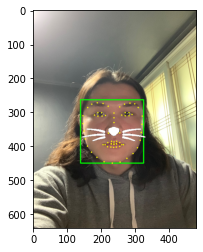

In [13]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### img_show 대신 저장해둔 랜드마크가 없는 img_bgr을 이용하여 스티커를 적용하고 이미지를 출력합니다.

img_bgr은 cvtColor을 통해서 rgb로 보정을 해주고 출력합니다.

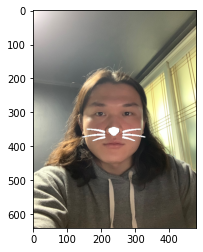

In [14]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#### 이미지에 고양이 수염 스티커가 잘 적용되어 나옴을 확인할 수 있습니다.

### 다른 각도 이미지에 스티커 적용해보기

#### 이미지를 불러옵니다.

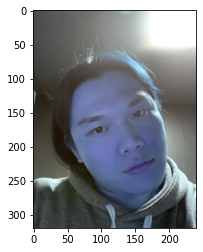

In [15]:
my_image_path1 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image1.png'
img_bgr1 = cv2.imread(my_image_path1)    # OpenCV로 이미지를 불러옵니다
img_show1 = img_bgr1.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr1)
plt.show()

#### 위에서 보이는 것과 같이 opencv는 BGR로 출력이 되어서 이미지가 푸르스름하게 출력됩니다.
#### BGR을 RGB로 보정합니다.

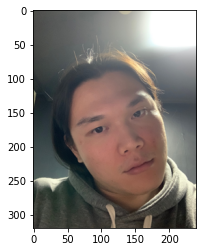

In [16]:
img_rgb1 = cv2.cvtColor(img_bgr1, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb1)
plt.show()

#### detector을 통해서 얼굴을 찾아내고 이미지를 출력합니다.

rectangles[[(64, 116) (218, 270)]]


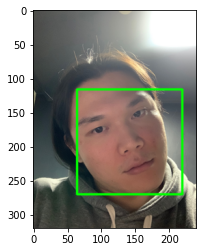

In [17]:
dlib_rects = detector_hog(img_rgb1, 1)

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show1, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb1 =  cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb1)
plt.show()

#### 출력된 이미지를 보면 얼굴의 각도는 비스듬하지만 녹색 박스는 얼굴에 따라서 움직이지 않는 것을 알 수 있습니다.

#### 저장한 landmark 모델을 불러온 다음 얼굴 영역 박스 마다 face landmark를 찾아냅니다.

In [18]:
# landmark 모델을 불러옵니다
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks1 = []

# 얼굴 영역 박스에서 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks1.append(list_points)

print(len(list_landmarks1[0]))

68


#### 랜드마크를 이미지에 적용하고 출력합니다.

녹색박스가 얼굴의 각도에 맞지 않기 때문에 랜드마크도 이상하게 적용되어 출력됨을 알 수 있습니다.

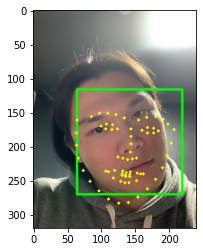

In [19]:
for landmark in list_landmarks1:
    for point in landmark:
        cv2.circle(img_show1, point, 2, (0, 255, 255), -1)

img_show_rgb1 = cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb1)
plt.show()

#### 고양이 수염을 정확하게 적용하기 위해서 코 끝 중간 부분의 랜드마크 좌표를 이용해 줍니다.

In [20]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks1):
    print (landmark[33]) # 코 끝 중앙부의 index는 33 입니다
    x = landmark[33][0]
    y = landmark[33][1] + dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(138, 219)
(x,y) : (138,296)
(w,h) : (155,155)


#### 고양이 수염 스티커의 이미지를 읽어 적용합니다.

흰색 배경을 색 반전을 해줍니다.

In [21]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = 255 - img_sticker
print (img_sticker.shape)

(155, 155, 3)


#### 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다.

In [22]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (61,141)


#### 이미지에 스티커를 적용하고 출력합니다.

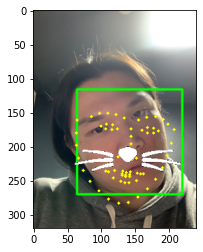

In [23]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area1 = img_show1[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show1[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area1,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB))
plt.show()

#### 랜드마크가 없는 img_bgr1을 이용해주고 rgb로 색보정을 해준 다음 이미지를 출력합니다.

이미지에 스티커가 정확하지 않게 출력됨을 확인할 수 있습니다.

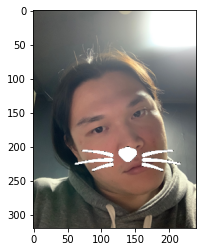

In [24]:
sticker_area1 = img_bgr1[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr1[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area1,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr1, cv2.COLOR_BGR2RGB))
plt.show()

## 회고

얼굴의 각도가 바뀌지 않은 첫 번째 사진에서는 얼굴의 녹색 박스가 제대로 출력되고 이목구비의 랜드마크도 제대로 나오는 것을 알 수 있었습니다.

랜드마크가 정확하게 나오니 고양이 수염 스티커도 제대로된 위치에 출력되는 것을 볼 수 있었습니다.

하지만 얼굴의 각도를 비스듬하게 찍은 사진에서는 스티커가 제대로 이상하게 나왔습니다.

사진의 각도가 바뀌어도 녹색 박스 rectangle의 각도는 변하지 않고 그대로 출력되었습니다.

녹색 박스의 각도가 변하지 않았기에 랜드마크의 위치도 변하지 않고 첫 번째 사진과 같은 자리에 찍혔습니다.

그로 인해서 스티커가 부정확한 곳에 찍혔습니다.

사진의 각도에 따라서 녹색 박스 rectangle의 각도가 변한다면 이목구비 랜드마크가 정확하게 찍힐 것이고 스티커도 제대로 찍힐 것 같습니다.

아직 어떻게 얼굴 각도에 따라서 녹색 박스를 적용하는 지 방법을 찾지는 못했습니다...



스티커가 제 사진에 적용되는 것을 바로 눈으로 확인할 수 있어서 재미있는 프로젝트였습니다.